<a href="https://colab.research.google.com/github/Rogerio-mack/fNIRS/blob/main/MB99_checkEpochs_snirf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install & import `nilearn` and `mne-nirs`

In [1]:
#@markdown
!pip install nilearn
!pip install -U --no-deps https://github.com/mne-tools/mne-python/archive/main.zip
!pip install mne-nirs

from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne 



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 5.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 61.5 MB 158 kB/s
  Created wheel for mne: filename=mne-1.1.dev0-py3-none-any.whl size=7434596 sha256=82e532a4b673fb887469b62831af94d0289c359c9b16e3b5ee9fbfa3c924e688
  Stored in directory: /tmp/pip-ephem-wheel-cache-0o75y2vp/wheels/66/fc/d2/9d32190e71b475

## Mount Google Drive

In [28]:
#@markdown
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Common Imports

In [3]:
#@markdown 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

import h5py
from itertools import compress
from sklearn.preprocessing import scale
from google.colab import widgets

In [29]:
path = '/content/drive/MyDrive/cond 1/snirf/snirf2/'

df_epochs_all = pd.read_excel( path + '13_run1_epochs.xlsx')
df_epochs_all.head()

,time,condition,epoch,S1_D1 hbo,S1_D1 hbr,S1_D8 hbo,S1_D8 hbr,S1_D14 hbo,S1_D14 hbr,S2_D2 hbo,...,S5_D14 hbo,S5_D14 hbr,S5_D15 hbo,S5_D15 hbr,S6_D10 hbo,S6_D10 hbr,S6_D12 hbo,S6_D12 hbr,S6_D13 hbo,S6_D13 hbr
0,-5000,Sync1,0,-30.296634,4.430723,18.277131,-2.247093,23.024617,-1.596118,-5.929954,...,-8.278716,-6.791902,-11.194100,-8.175648,-1.339165,-0.612124,-2.690123,0.073800,-3.202219,-1.364084
1,-4900,Sync1,0,-26.593105,3.964138,15.887014,-1.970417,28.160595,-2.176457,-6.027119,...,-6.720704,-6.026266,-10.047608,-7.546052,-1.408700,-0.017622,-2.453076,0.121582,-3.088091,-1.302326
2,-4800,Sync1,0,-19.472262,3.074325,10.894687,-1.336523,30.051818,-2.438888,-5.450200,...,-5.125164,-5.218035,-8.671589,-6.801530,-1.390504,0.480391,-2.176323,0.132601,-2.886142,-1.205823
3,-4700,Sync1,0,-9.829956,1.855114,4.556012,-0.498665,28.018809,-2.286079,-4.321715,...,-3.553986,-4.397760,-7.119993,-5.966014,-1.248674,0.826261,-1.857001,0.106632,-2.581486,-1.085013
4,-4600,Sync1,0,1.152734,0.453505,-1.785917,0.371654,22.242439,-1.715520,-2.793562,...,-2.070517,-3.599954,-5.482181,-5.080049,-0.978065,0.995988,-1.502927,0.049445,-2.185497,-0.956485


In [32]:
channel_SD = pd.read_csv('https://github.com/Rogerio-mack/fNIRS/raw/main/channel_types.csv')

channel_SD_selected = channel_SD
channel_SD_selected

,channel_name,channel_type,channel_hole
0,S1_D1,Motor,Hole1(D1-B2)
1,S1_D8,Motor,Hole9(D8-B2)
2,S1_D14,Motor,Hole20(D6-B3)
3,S2_D2,Motor,Hole2(B2-D2)
4,S2_D3,Motor,Hole3(B2-D3)
5,S2_D8,Motor,Hole9(D8-D2)
6,S2_D9,Motor,Hole13(D1-B3)
7,S2_D11,Parietal,Hole16(D3-B3)
8,S3_D4,Parietal,Hole4(D4-B2)
9,S3_D5,Parietal,Hole5(D5-B2)


In [35]:
Motor_channels = channel_SD_selected[channel_SD_selected.channel_type == 'Motor']['channel_name'].tolist()
Parietal_channels = channel_SD_selected[channel_SD_selected.channel_type == 'Parietal']['channel_name'].to_list()
print(Motor_channels)
print(Parietal_channels)

['S1_D1', 'S1_D8', 'S1_D14', 'S2_D2', 'S2_D3', 'S2_D8', 'S2_D9', 'S3_D9', 'S5_D8', 'S5_D14', 'S5_D15']
['S2_D11', 'S3_D4', 'S3_D5', 'S3_D10', 'S3_D12', 'S4_D6', 'S4_D7', 'S4_D10', 'S4_D13', 'S5_D11', 'S6_D10', 'S6_D12', 'S6_D13']


In [36]:
HBO_Motor_channels = [ x for x in df_epochs_all.columns if 'hbo' in x and x.split(' ')[0] in Motor_channels ]
print(HBO_Motor_channels)

HBR_Motor_channels = [ x for x in df_epochs_all.columns if 'hbr' in x and x.split(' ')[0] in Motor_channels ]
print(HBR_Motor_channels)

HBO_Parietal_channels = [ x for x in df_epochs_all.columns if 'hbo' in x and x.split(' ')[0] in Parietal_channels ]
print(HBO_Parietal_channels)

HBR_Parietal_channels = [ x for x in df_epochs_all.columns if 'hbr' in x and x.split(' ')[0] in Parietal_channels ]
print(HBR_Parietal_channels)

['S1_D1 hbo', 'S1_D8 hbo', 'S1_D14 hbo', 'S2_D2 hbo', 'S2_D3 hbo', 'S2_D8 hbo', 'S2_D9 hbo', 'S3_D9 hbo', 'S5_D8 hbo', 'S5_D14 hbo', 'S5_D15 hbo']
['S1_D1 hbr', 'S1_D8 hbr', 'S1_D14 hbr', 'S2_D2 hbr', 'S2_D3 hbr', 'S2_D8 hbr', 'S2_D9 hbr', 'S3_D9 hbr', 'S5_D8 hbr', 'S5_D14 hbr', 'S5_D15 hbr']
['S2_D11 hbo', 'S3_D4 hbo', 'S3_D5 hbo', 'S3_D10 hbo', 'S3_D12 hbo', 'S4_D6 hbo', 'S4_D7 hbo', 'S4_D10 hbo', 'S4_D13 hbo', 'S5_D11 hbo', 'S6_D10 hbo', 'S6_D12 hbo', 'S6_D13 hbo']
['S2_D11 hbr', 'S3_D4 hbr', 'S3_D5 hbr', 'S3_D10 hbr', 'S3_D12 hbr', 'S4_D6 hbr', 'S4_D7 hbr', 'S4_D10 hbr', 'S4_D13 hbr', 'S5_D11 hbr', 'S6_D10 hbr', 'S6_D12 hbr', 'S6_D13 hbr']


In [37]:
df_epochs_mean = df_epochs_all[['time', 'condition', 'epoch']].copy()

HBO_Motor, HBR_Motor, HBO_Parietal, HBR_Parietal = [], [], [], []
for _, row in df_epochs_all.iterrows():
  HBO_Motor.append( row[ HBO_Motor_channels ].mean() )
  HBR_Motor.append( row[ HBR_Motor_channels ].mean() )
  HBO_Parietal.append( row[ HBO_Parietal_channels ].mean() )
  HBR_Parietal.append( row[ HBR_Parietal_channels ].mean() )

df_epochs_mean['HBO_Motor'] = HBO_Motor
df_epochs_mean['HBR_Motor'] = HBR_Motor
df_epochs_mean['HBO_Parietal'] = HBO_Parietal
df_epochs_mean['HBR_Parietal'] = HBR_Parietal

df_epochs_mean.head()

,time,condition,epoch,HBO_Motor,HBR_Motor,HBO_Parietal,HBR_Parietal
0,-5000,Sync1,0,-1.987838,0.307315,-1.149973,0.294772
1,-4900,Sync1,0,-1.195403,0.648987,-1.003921,0.453245
2,-4800,Sync1,0,-0.480706,0.887009,-0.798867,0.575032
3,-4700,Sync1,0,0.117092,0.995879,-0.513566,0.638440
4,-4600,Sync1,0,0.604367,0.964065,-0.143322,0.630399


In [38]:
df_epochs_mean['condition_phase'] = df_epochs_mean['condition'].apply(lambda x: x[-1])

In [39]:
df_epochs_mean['condition_type'] = df_epochs_mean['condition'].apply(lambda x: x[0:-1])

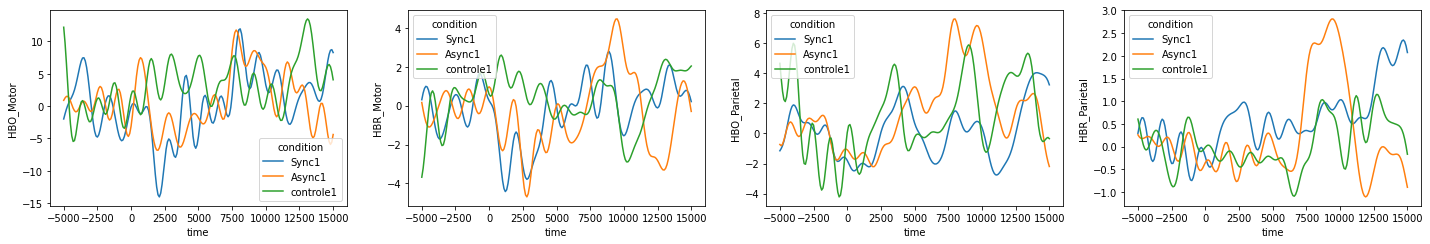

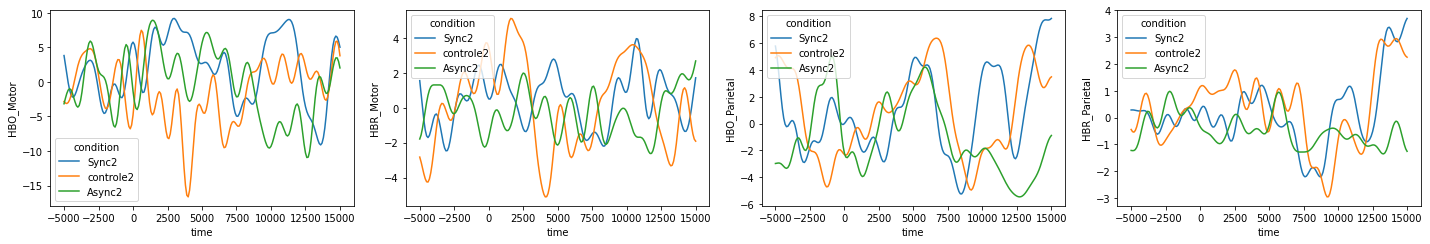

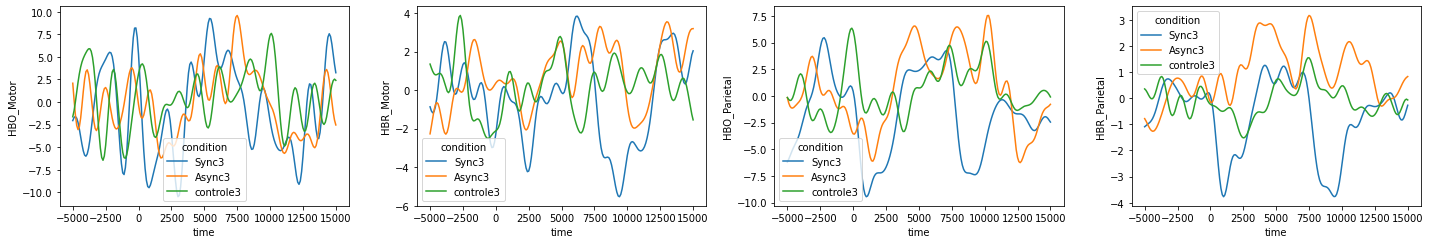

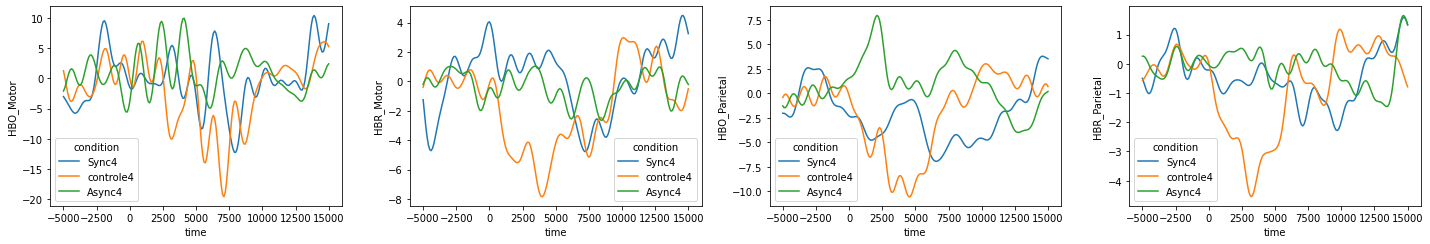

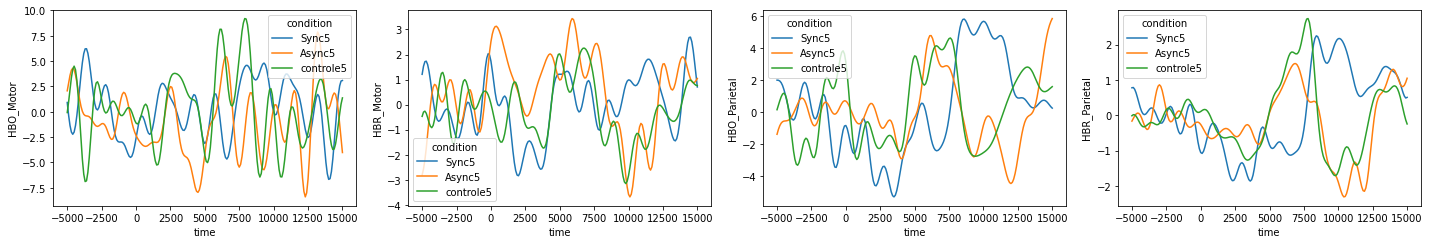

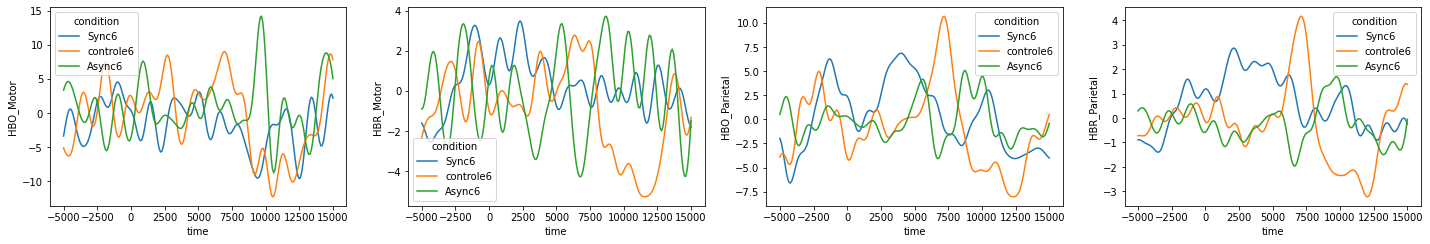

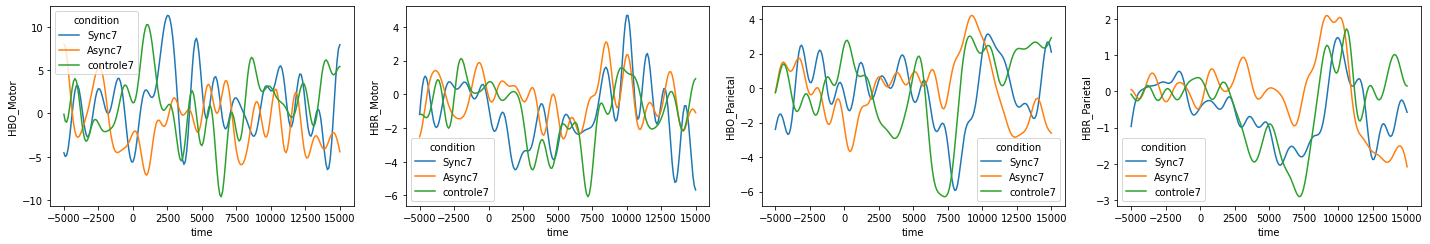

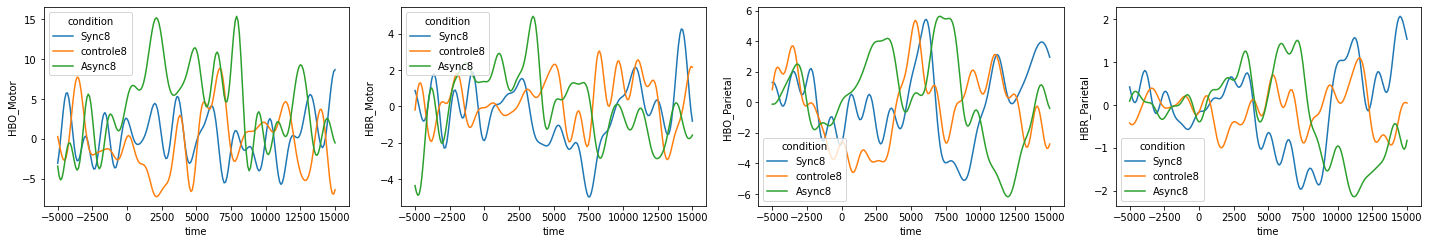

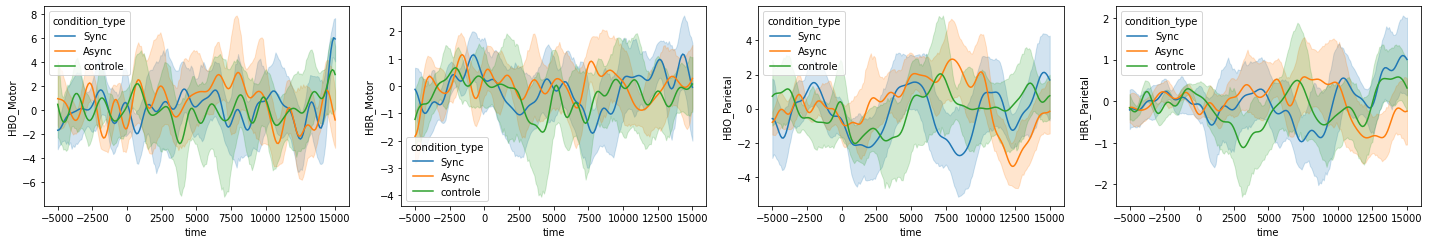

In [42]:
for i in range(1,9):
  fig = plt.figure(figsize=(20,3.5))
  plt.subplot(1,4,1)
  sns.lineplot(x='time', y='HBO_Motor', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])
  plt.subplot(1,4,2)
  sns.lineplot(x='time', y='HBR_Motor', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])
  plt.subplot(1,4,3)
  sns.lineplot(x='time', y='HBO_Parietal', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])
  plt.subplot(1,4,4)
  sns.lineplot(x='time', y='HBR_Parietal', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])

  plt.tight_layout()
  plt.show()

fig = plt.figure(figsize=(20,3.5))
plt.subplot(1,4,1)
sns.lineplot(x='time', y='HBO_Motor', hue='condition_type', data=df_epochs_mean )
plt.subplot(1,4,2)
sns.lineplot(x='time', y='HBR_Motor', hue='condition_type', data=df_epochs_mean )
plt.subplot(1,4,3)
sns.lineplot(x='time', y='HBO_Parietal', hue='condition_type', data=df_epochs_mean )
plt.subplot(1,4,4)
sns.lineplot(x='time', y='HBR_Parietal', hue='condition_type', data=df_epochs_mean )

plt.tight_layout()
plt.show()

In [43]:
entries = []
for f in os.listdir(path):
  if '_epochs.xlsx' in f:
    entries.append(f)

entries

['17_run1_epochs.xlsx',
 '33_run1_epochs.xlsx',
 '36_run1_epochs.xlsx',
 '34_run1_epochs.xlsx',
 '14_run1_epochs.xlsx',
 '13_run1_epochs.xlsx',
 '5_run1_epochs.xlsx',
 '38_run1_epochs.xlsx',
 '29_run1_epochs.xlsx',
 '25_run1_epochs.xlsx',
 '31_run1_epochs.xlsx']

In [44]:
df_epochs_all.shape

(4824, 51)

In [45]:
df_epochs_total = pd.DataFrame()

for f in entries:
  df =  pd.read_excel( path + f )
  df_epochs_total = pd.concat([ df_epochs_total , df])

df_epochs_total.shape

(53064, 51)

In [46]:
df_epochs_mean = df_epochs_total[['time', 'condition', 'epoch']].copy()

HBO_Motor, HBR_Motor, HBO_Parietal, HBR_Parietal = [], [], [], []
for _, row in df_epochs_total.iterrows():
  HBO_Motor.append( row[ HBO_Motor_channels ].mean() )
  HBR_Motor.append( row[ HBR_Motor_channels ].mean() )
  HBO_Parietal.append( row[ HBO_Parietal_channels ].mean() )
  HBR_Parietal.append( row[ HBR_Parietal_channels ].mean() )

df_epochs_mean['HBO_Motor'] = HBO_Motor
df_epochs_mean['HBR_Motor'] = HBR_Motor
df_epochs_mean['HBO_Parietal'] = HBO_Parietal
df_epochs_mean['HBR_Parietal'] = HBR_Parietal

df_epochs_mean.head()

,time,condition,epoch,HBO_Motor,HBR_Motor,HBO_Parietal,HBR_Parietal
0,-5000,Sync1,0,-5.281026,-3.146210,-5.114706,-2.235432
1,-4900,Sync1,0,-3.425852,-3.681317,-4.061882,-1.861708
2,-4800,Sync1,0,-2.017665,-3.993404,-3.259115,-1.455824
3,-4700,Sync1,0,-1.197868,-4.131965,-2.770188,-1.064699
4,-4600,Sync1,0,-0.996569,-4.159042,-2.611271,-0.727627


In [47]:
df_epochs_mean['condition_phase'] = df_epochs_mean['condition'].apply(lambda x: x[-1])

In [48]:
df_epochs_mean['condition_type'] = df_epochs_mean['condition'].apply(lambda x: x[0:-1])

In [49]:
df_epochs_mean = df_epochs_mean.reset_index(drop=True)
df_epochs_mean.head()

,time,condition,epoch,HBO_Motor,HBR_Motor,HBO_Parietal,HBR_Parietal,condition_phase,condition_type
0,-5000,Sync1,0,-5.281026,-3.146210,-5.114706,-2.235432,1,Sync
1,-4900,Sync1,0,-3.425852,-3.681317,-4.061882,-1.861708,1,Sync
2,-4800,Sync1,0,-2.017665,-3.993404,-3.259115,-1.455824,1,Sync
3,-4700,Sync1,0,-1.197868,-4.131965,-2.770188,-1.064699,1,Sync
4,-4600,Sync1,0,-0.996569,-4.159042,-2.611271,-0.727627,1,Sync


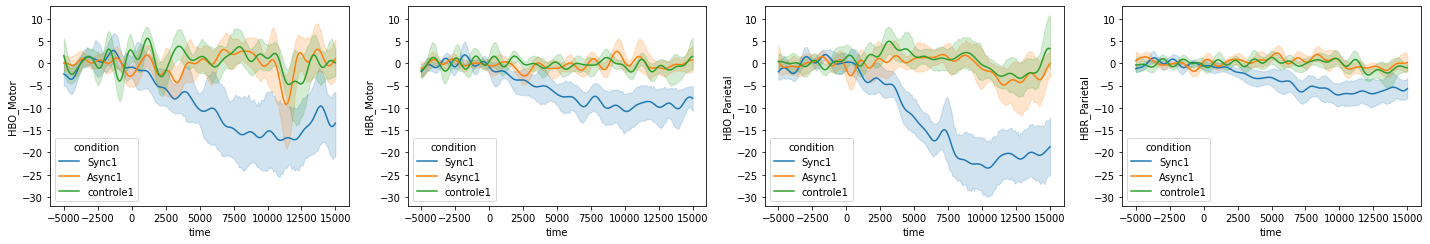

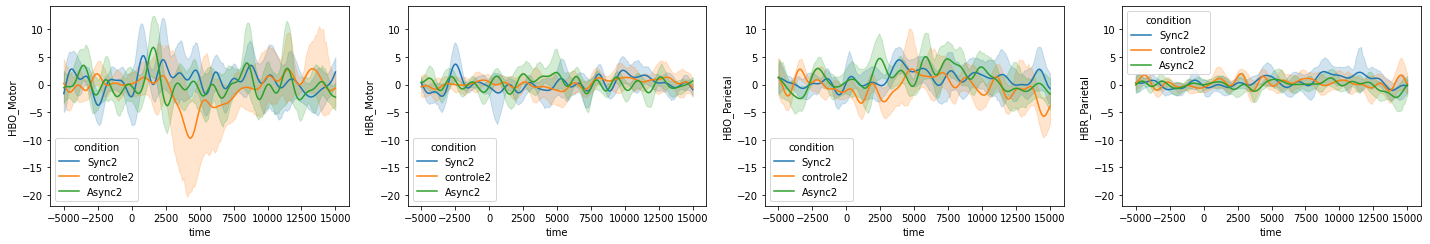

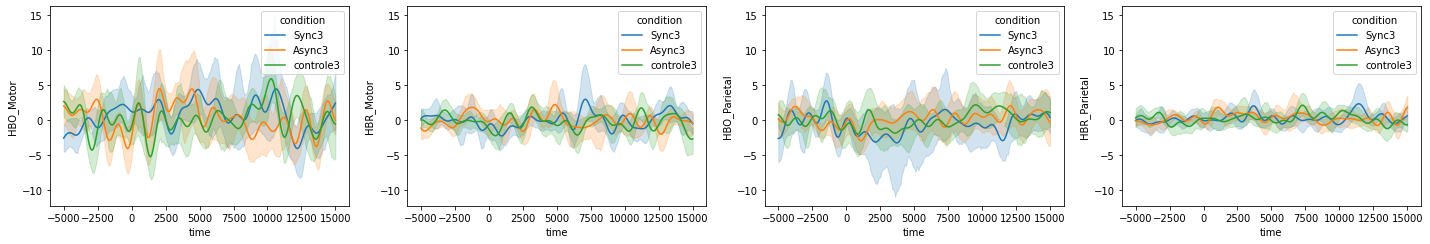

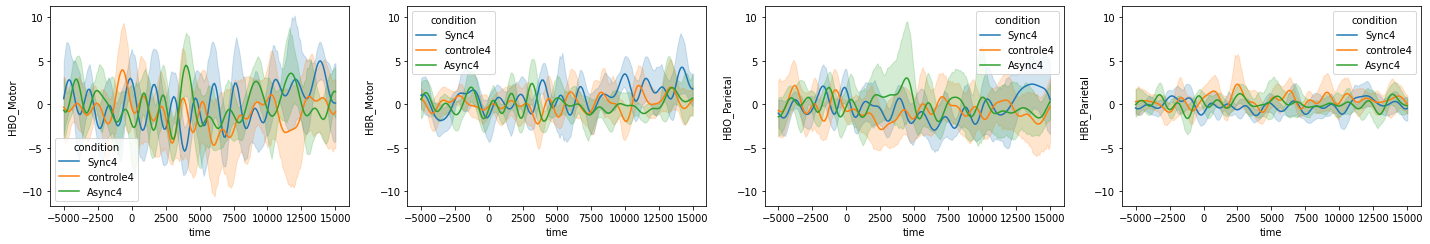

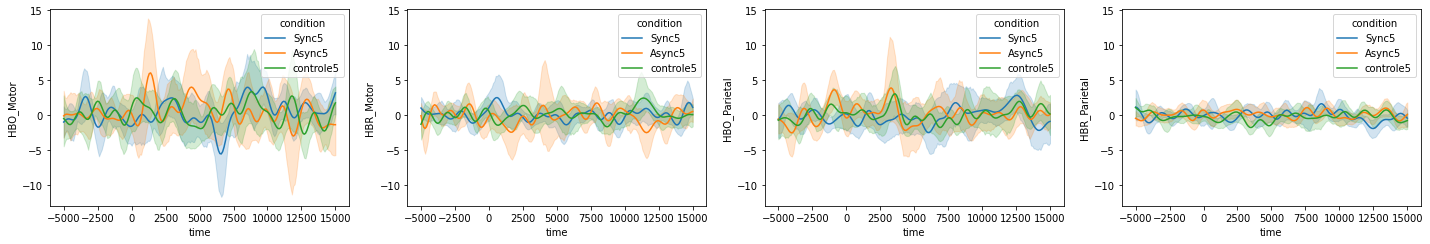

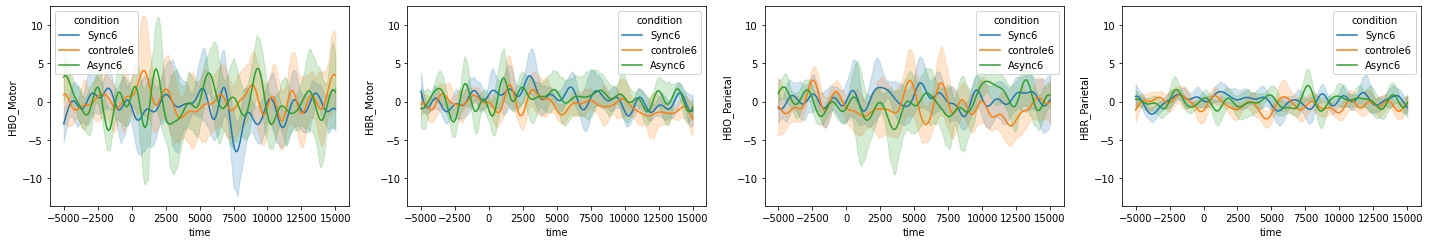

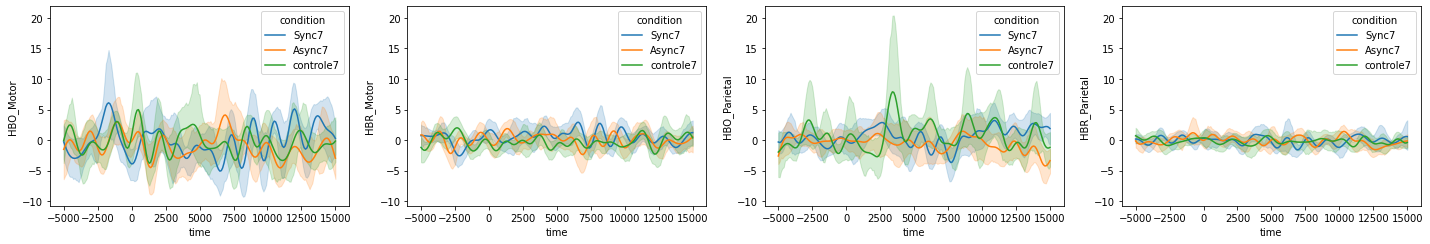

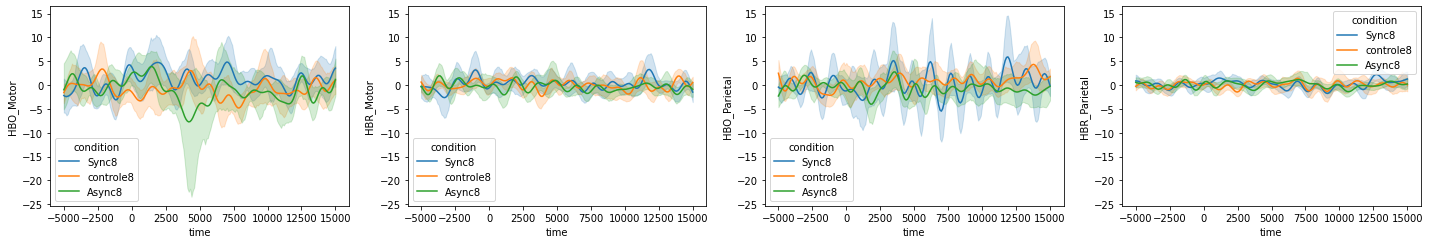

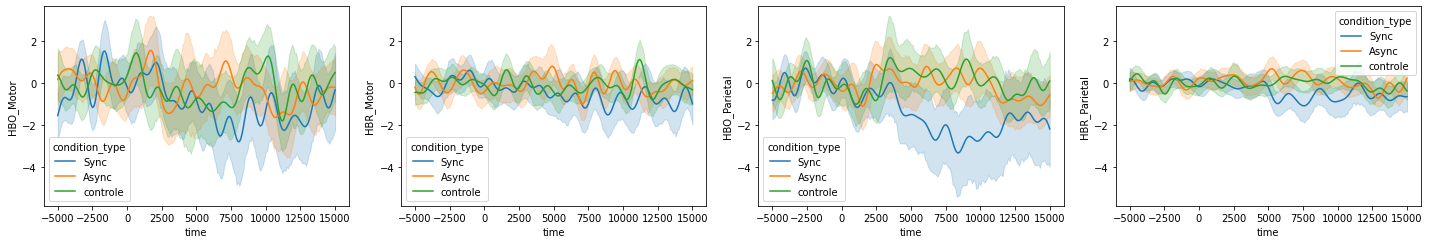

In [50]:
for i in range(1,9):
  fig = plt.figure(figsize=(20,3.5))
  ax1 = plt.subplot(1,4,1)
  sns.lineplot(x='time', y='HBO_Motor', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])
  plt.subplot(1,4,2, sharey = ax1 )
  sns.lineplot(x='time', y='HBR_Motor', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])
  plt.subplot(1,4,3, sharey = ax1 )
  sns.lineplot(x='time', y='HBO_Parietal', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])
  plt.subplot(1,4,4, sharey = ax1 )
  sns.lineplot(x='time', y='HBR_Parietal', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])

  plt.tight_layout()
  plt.show()

fig = plt.figure(figsize=(20,3.5))
ax1 = plt.subplot(1,4,1)
sns.lineplot(x='time', y='HBO_Motor', hue='condition_type', data=df_epochs_mean )
plt.subplot(1,4,2, sharey = ax1 )
sns.lineplot(x='time', y='HBR_Motor', hue='condition_type', data=df_epochs_mean )
plt.subplot(1,4,3, sharey = ax1 )
sns.lineplot(x='time', y='HBO_Parietal', hue='condition_type', data=df_epochs_mean )
plt.subplot(1,4,4, sharey = ax1 )
sns.lineplot(x='time', y='HBR_Parietal', hue='condition_type', data=df_epochs_mean )

plt.tight_layout()
plt.show()